MARKETPLACE LIQUIDITY SQL ANALYSIS

1. SUPPLY METRICS
----------------------------------------


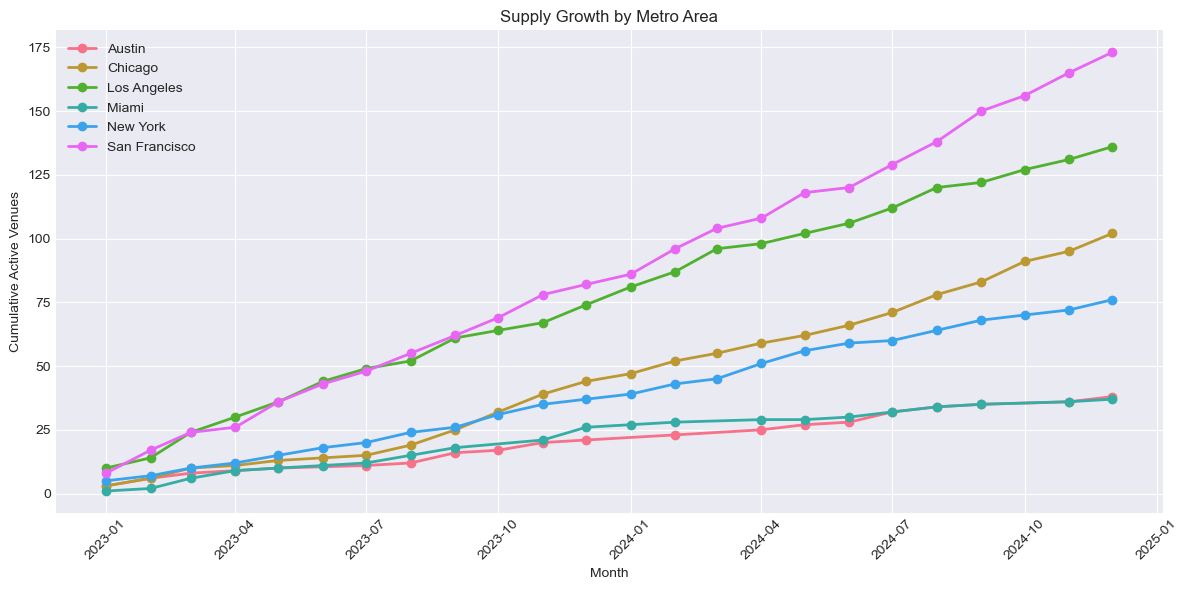

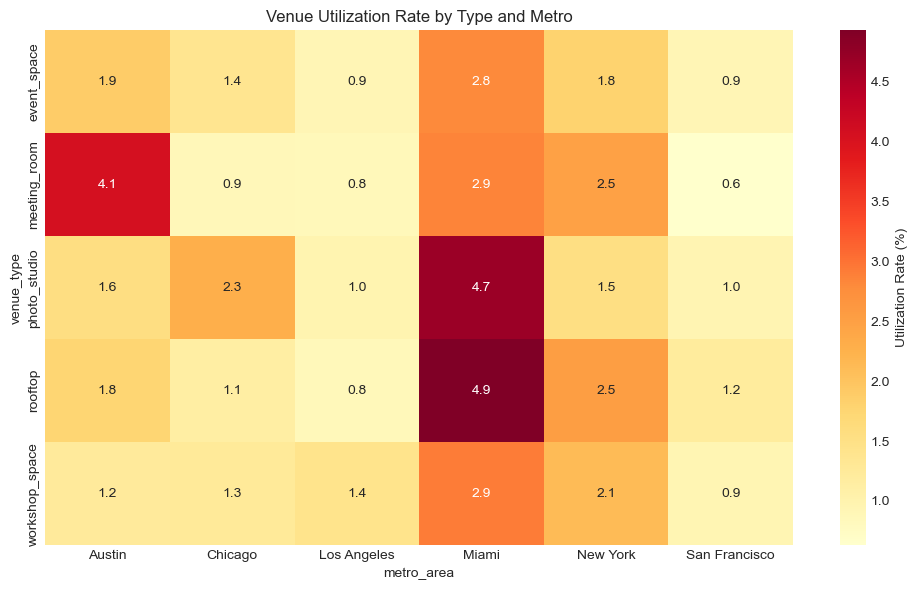


✓ Supply Metrics Analyzed
  - Highest utilization: 4.9%
  - Lowest utilization: 0.6%

2. DEMAND METRICS
----------------------------------------


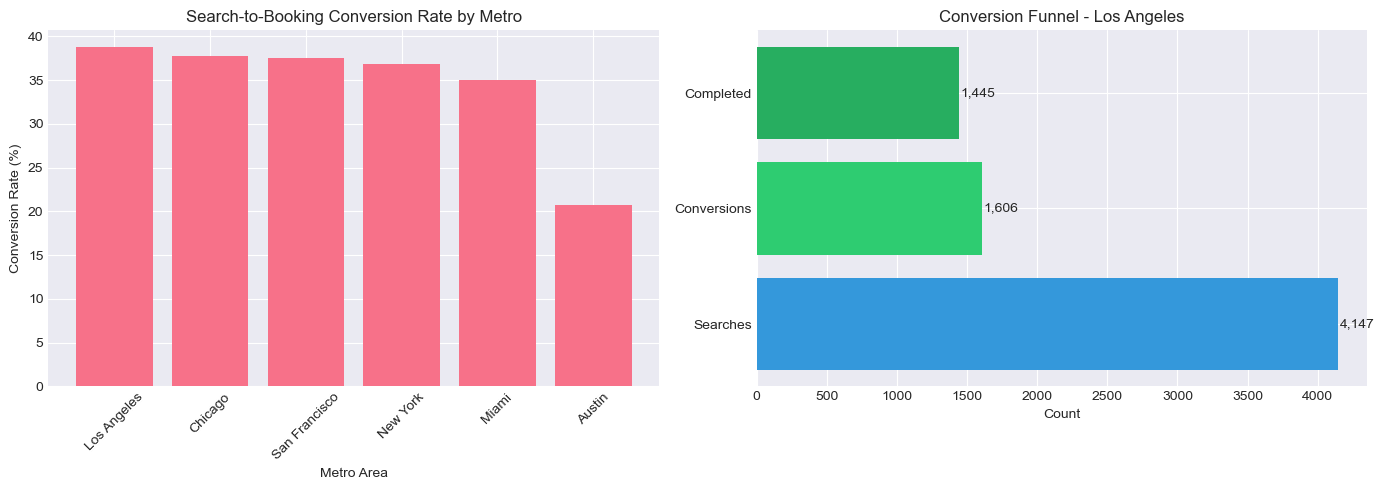


✓ Demand Metrics Analyzed
  - Best conversion rate: 38.7% (Los Angeles)
  - Worst conversion rate: 20.7% (Austin)

3. LIQUIDITY SCORE CALCULATION
----------------------------------------


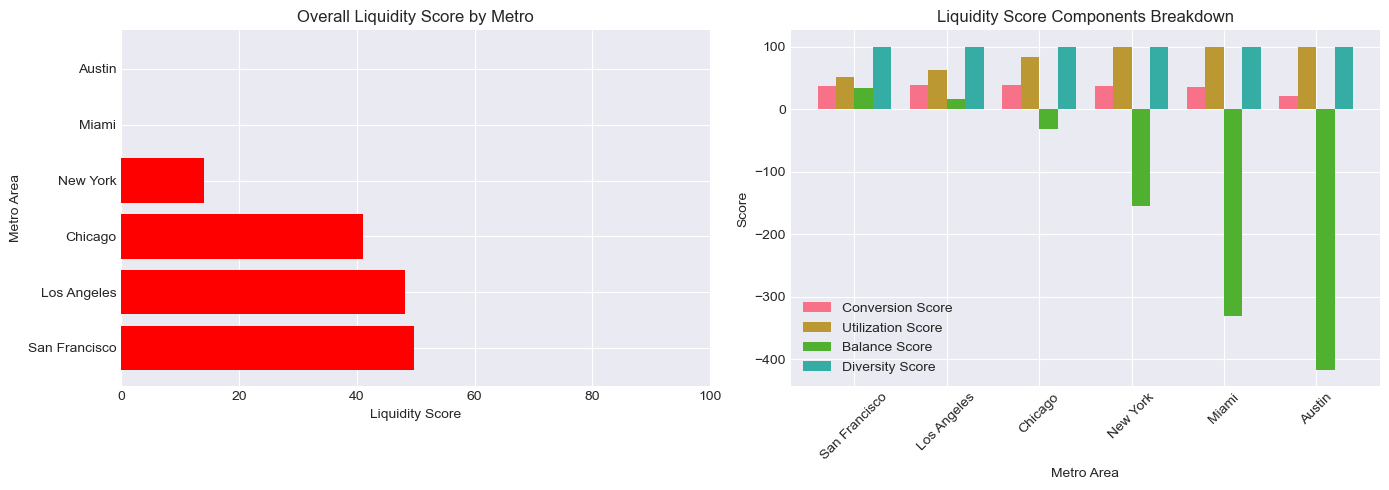


✓ Liquidity Scores Calculated

Liquidity Rankings:
  1. San Francisco: 49.7 (Needs Attention)
  2. Los Angeles: 48.2 (Needs Attention)
  3. Chicago: 41.0 (Needs Attention)
  4. New York: 14.0 (Needs Attention)
  5. Miami: -30.6 (Needs Attention)
  6. Austin: -57.2 (Needs Attention)

4. ACTIONABLE INSIGHTS
----------------------------------------


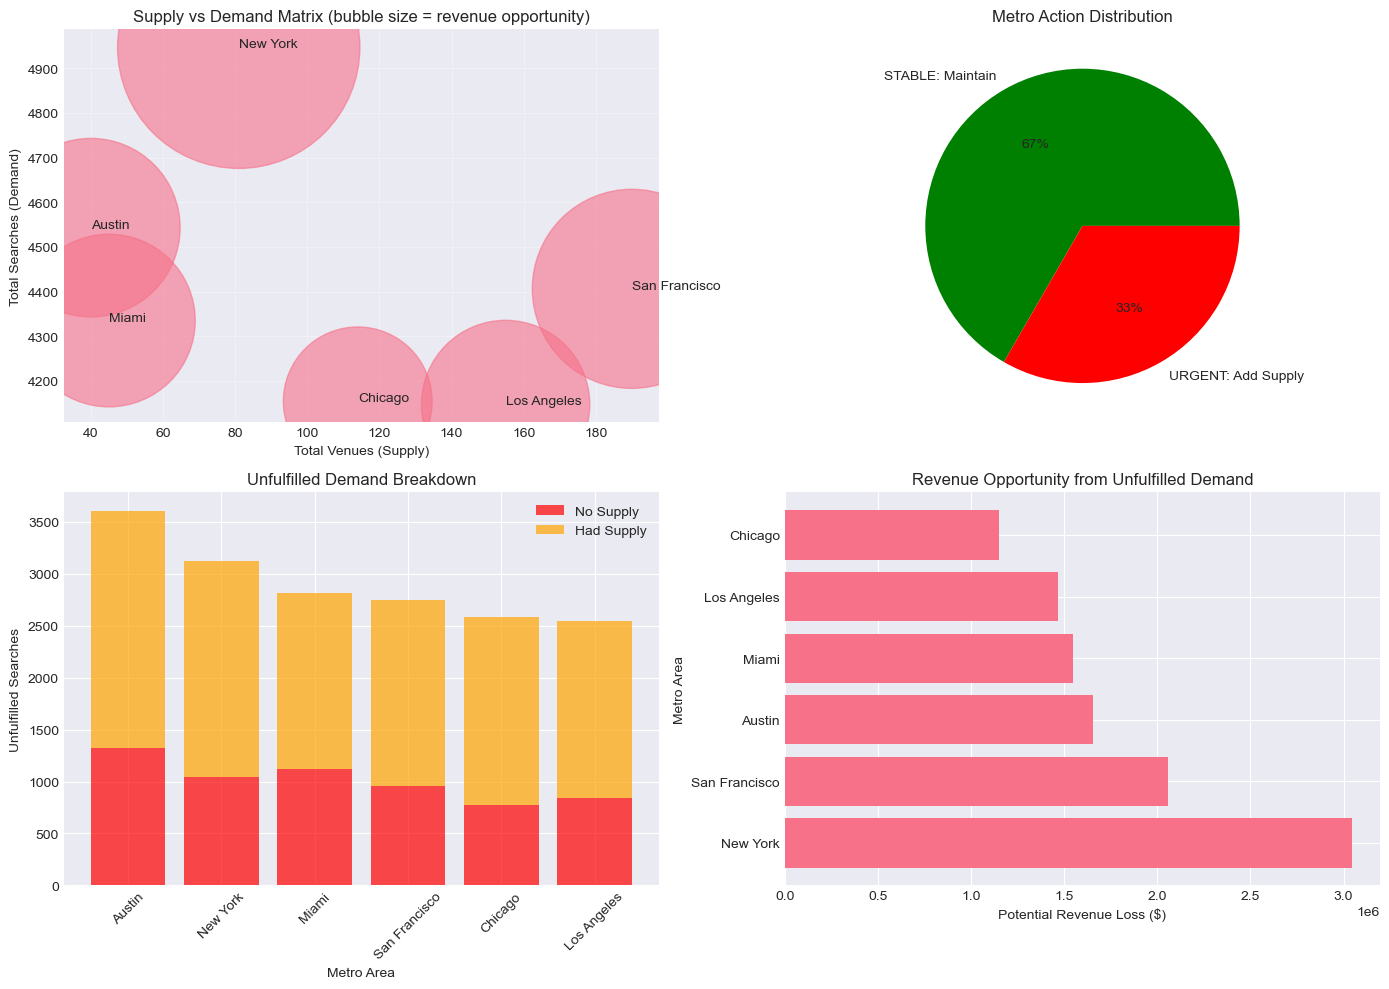


✓ Actionable Insights Generated

Priority Actions by Metro:

New York:
  Action: STABLE: Maintain
  Potential Revenue Loss: $3,043,602.91
  Current Conversion: 36.8%

San Francisco:
  Action: STABLE: Maintain
  Potential Revenue Loss: $2,054,918.40
  Current Conversion: 37.5%

Austin:
  Action: URGENT: Add Supply
  Potential Revenue Loss: $1,652,741.68
  Current Conversion: 20.7%

Miami:
  Action: URGENT: Add Supply
  Potential Revenue Loss: $1,545,617.92
  Current Conversion: 35.0%

Los Angeles:
  Action: STABLE: Maintain
  Potential Revenue Loss: $1,469,079.15
  Current Conversion: 38.7%

Chicago:
  Action: STABLE: Maintain
  Potential Revenue Loss: $1,147,864.48
  Current Conversion: 37.8%

5. TIME SERIES TRENDS
----------------------------------------


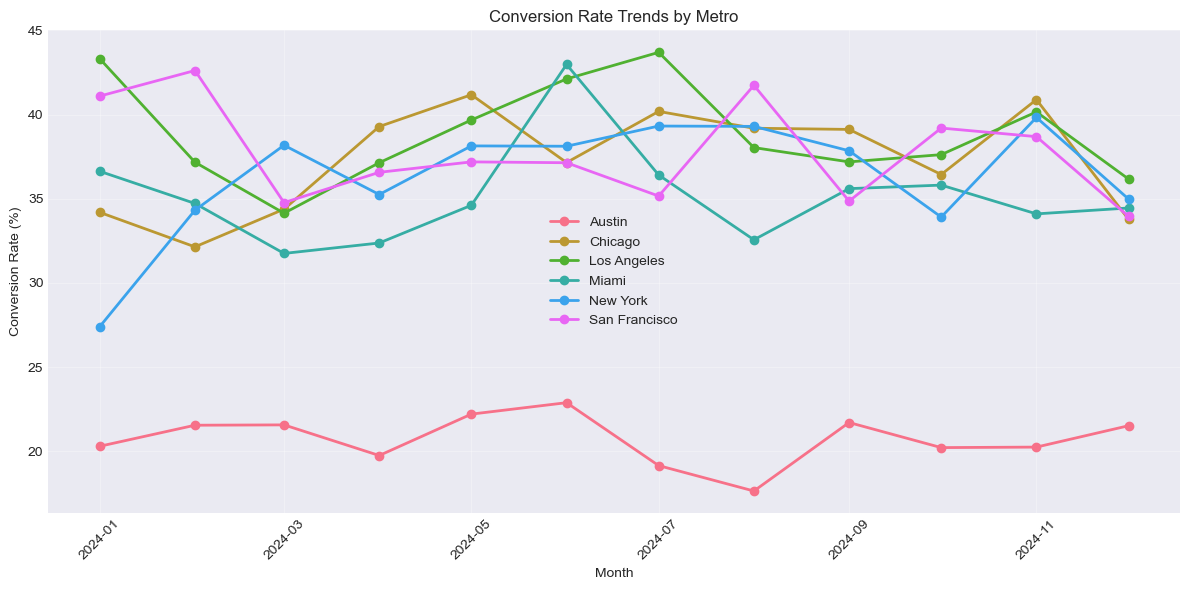


✓ Time Series Analysis Complete

LIQUIDITY ANALYSIS SUMMARY

📊 KEY FINDINGS:
----------------------------------------

✅ BEST PERFORMING METRO: San Francisco
   - Liquidity Score: 49.7
   - Market Health: Needs Attention
   - Supply/Demand: 190 venues / 4406 searches

⚠️  NEEDS ATTENTION: Austin
   - Liquidity Score: -57.2
   - Market Health: Needs Attention
   - Supply/Demand: 40 venues / 4543 searches

💰 TOTAL REVENUE OPPORTUNITY: $10,913,824.54

🏢 METROS WITH SUPPLY GAPS (>30% unfulfilled due to no supply):
   - Austin: 36.8% true supply gap
   - New York: 33.4% true supply gap
   - Miami: 40.0% true supply gap
   - San Francisco: 34.7% true supply gap
   - Los Angeles: 33.1% true supply gap

📈 RECOMMENDATIONS:
----------------------------------------

Austin: URGENT: Add Supply
   → Launch host acquisition campaign
   → Target: Add 20-30 new venues
   → Focus on high-demand venue types

Miami: URGENT: Add Supply
   → Launch host acquisition campaign
   → Target: Add 20-30 new venu

In [1]:
# SQL Analysis Execution Notebook
# This notebook runs the SQL queries and visualizes the results

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Connect to database
conn = sqlite3.connect('../data/peerspace_marketplace.db')

print("="*60)
print("MARKETPLACE LIQUIDITY SQL ANALYSIS")
print("="*60)

# =====================================================
# SECTION 1: SUPPLY METRICS
# =====================================================

print("\n1. SUPPLY METRICS")
print("-"*40)

# 1.1 Active Listings Growth
query_supply_growth = """
WITH monthly_supply AS (
    SELECT 
        metro_area,
        DATE(created_date, 'start of month') as month,
        COUNT(DISTINCT venue_id) as total_venues,
        COUNT(DISTINCT CASE WHEN is_active = 1 THEN venue_id END) as active_venues
    FROM listings
    GROUP BY metro_area, DATE(created_date, 'start of month')
),
cumulative_supply AS (
    SELECT 
        metro_area,
        month,
        SUM(active_venues) OVER (PARTITION BY metro_area ORDER BY month) as cumulative_active_venues
    FROM monthly_supply
)
SELECT 
    metro_area,
    month,
    cumulative_active_venues
FROM cumulative_supply
ORDER BY metro_area, month
"""

supply_growth_df = pd.read_sql_query(query_supply_growth, conn)
supply_growth_df['month'] = pd.to_datetime(supply_growth_df['month'])

# Visualize supply growth
fig, ax = plt.subplots(figsize=(12, 6))
for metro in supply_growth_df['metro_area'].unique():
    metro_data = supply_growth_df[supply_growth_df['metro_area'] == metro]
    ax.plot(metro_data['month'], metro_data['cumulative_active_venues'], 
            marker='o', label=metro, linewidth=2)

ax.set_xlabel('Month')
ax.set_ylabel('Cumulative Active Venues')
ax.set_title('Supply Growth by Metro Area')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 1.2 Utilization Analysis
query_utilization = """
WITH venue_bookings AS (
    SELECT 
        l.venue_id,
        l.metro_area,
        l.venue_type,
        COUNT(DISTINCT b.booking_id) as total_bookings,
        SUM(b.hours_booked) as total_hours_booked
    FROM listings l
    LEFT JOIN bookings b 
        ON l.venue_id = b.venue_id 
        AND b.status = 'completed'
    GROUP BY l.venue_id, l.metro_area, l.venue_type
),
utilization_stats AS (
    SELECT 
        venue_id,
        metro_area,
        venue_type,
        total_bookings,
        ROUND(total_hours_booked * 100.0 / (10 * 365), 2) as utilization_rate
    FROM venue_bookings
)
SELECT 
    metro_area,
    venue_type,
    COUNT(*) as venue_count,
    ROUND(AVG(utilization_rate), 2) as avg_utilization_rate
FROM utilization_stats
GROUP BY metro_area, venue_type
ORDER BY metro_area, avg_utilization_rate DESC
"""

utilization_df = pd.read_sql_query(query_utilization, conn)

# Create heatmap of utilization
pivot_util = utilization_df.pivot(index='venue_type', 
                                   columns='metro_area', 
                                   values='avg_utilization_rate')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_util, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Utilization Rate (%)'})
plt.title('Venue Utilization Rate by Type and Metro')
plt.tight_layout()
plt.show()

print("\n✓ Supply Metrics Analyzed")
print(f"  - Highest utilization: {utilization_df['avg_utilization_rate'].max():.1f}%")
print(f"  - Lowest utilization: {utilization_df['avg_utilization_rate'].min():.1f}%")

# =====================================================
# SECTION 2: DEMAND METRICS
# =====================================================

print("\n2. DEMAND METRICS")
print("-"*40)

# 2.1 Search Volume Trends
query_demand = """
SELECT 
    metro_area,
    DATE(search_date, 'start of month') as month,
    COUNT(*) as total_searches,
    COUNT(DISTINCT user_id) as unique_searchers,
    AVG(JULIANDAY(event_date) - JULIANDAY(search_date)) as avg_lead_time_days
FROM searches
GROUP BY metro_area, DATE(search_date, 'start of month')
"""

demand_df = pd.read_sql_query(query_demand, conn)
demand_df['month'] = pd.to_datetime(demand_df['month'])

# 2.2 Conversion Funnel
query_conversion = """
WITH conversion_funnel AS (
    SELECT 
        s.metro_area,
        COUNT(DISTINCT s.search_id) as total_searches,
        COUNT(DISTINCT CASE WHEN s.search_resulted_in_booking = 1 THEN s.search_id END) as converted_searches,
        COUNT(DISTINCT b.booking_id) as total_bookings
    FROM searches s
    LEFT JOIN bookings b ON s.search_id = b.search_id
    GROUP BY s.metro_area
)
SELECT 
    metro_area,
    total_searches,
    converted_searches,
    ROUND(converted_searches * 100.0 / total_searches, 2) as conversion_rate
FROM conversion_funnel
ORDER BY conversion_rate DESC
"""

conversion_df = pd.read_sql_query(query_conversion, conn)

# Visualize conversion rates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of conversion rates
ax1.bar(conversion_df['metro_area'], conversion_df['conversion_rate'])
ax1.set_xlabel('Metro Area')
ax1.set_ylabel('Conversion Rate (%)')
ax1.set_title('Search-to-Booking Conversion Rate by Metro')
ax1.tick_params(axis='x', rotation=45)

# Funnel visualization for top metro
top_metro = conversion_df.iloc[0]['metro_area']
top_metro_data = conversion_df[conversion_df['metro_area'] == top_metro].iloc[0]
funnel_data = [
    top_metro_data['total_searches'],
    top_metro_data['converted_searches'],
    top_metro_data['converted_searches'] * 0.9  # Assuming 90% complete booking
]
funnel_labels = ['Searches', 'Conversions', 'Completed']

ax2.barh(range(len(funnel_data)), funnel_data, color=['#3498db', '#2ecc71', '#27ae60'])
ax2.set_yticks(range(len(funnel_labels)))
ax2.set_yticklabels(funnel_labels)
ax2.set_xlabel('Count')
ax2.set_title(f'Conversion Funnel - {top_metro}')

for i, v in enumerate(funnel_data):
    ax2.text(v + 10, i, f'{int(v):,}', va='center')

plt.tight_layout()
plt.show()

print("\n✓ Demand Metrics Analyzed")
print(f"  - Best conversion rate: {conversion_df['conversion_rate'].max():.1f}% ({conversion_df.iloc[0]['metro_area']})")
print(f"  - Worst conversion rate: {conversion_df['conversion_rate'].min():.1f}% ({conversion_df.iloc[-1]['metro_area']})")

# =====================================================
# SECTION 3: LIQUIDITY SCORE
# =====================================================

print("\n3. LIQUIDITY SCORE CALCULATION")
print("-"*40)

query_liquidity = """
WITH liquidity_components AS (
    SELECT 
        l.metro_area,
        COUNT(DISTINCT l.venue_id) as supply_count,
        COUNT(DISTINCT s.search_id) as demand_count,
        COUNT(DISTINCT b.booking_id) as booking_count,
        COUNT(DISTINCT CASE WHEN s.search_resulted_in_booking = 1 THEN s.search_id END) as converted_searches,
        COUNT(DISTINCT l.venue_type) as supply_diversity
    FROM listings l
    LEFT JOIN searches s ON l.metro_area = s.metro_area
    LEFT JOIN bookings b ON b.venue_id = l.venue_id AND b.status = 'completed'
    GROUP BY l.metro_area
),
liquidity_scores AS (
    SELECT 
        metro_area,
        supply_count,
        demand_count,
        booking_count,
        ROUND(converted_searches * 100.0 / NULLIF(demand_count, 0), 2) as conversion_score,
        ROUND(MIN(booking_count * 10.0 / NULLIF(supply_count, 0), 100), 2) as utilization_score,
        ROUND(100 - ABS(demand_count * 1.0 / NULLIF(supply_count, 0) - 10) * 5, 2) as balance_score,
        ROUND(supply_diversity * 20, 2) as diversity_score
    FROM liquidity_components
)
SELECT 
    metro_area,
    supply_count,
    demand_count,
    booking_count,
    conversion_score,
    utilization_score,
    balance_score,
    diversity_score,
    ROUND(
        conversion_score * 0.35 +
        utilization_score * 0.25 +
        balance_score * 0.25 +
        diversity_score * 0.15,
    2) as liquidity_score,
    CASE 
        WHEN (conversion_score * 0.35 + utilization_score * 0.25 + balance_score * 0.25 + diversity_score * 0.15) >= 70 THEN 'Healthy'
        WHEN (conversion_score * 0.35 + utilization_score * 0.25 + balance_score * 0.25 + diversity_score * 0.15) >= 50 THEN 'Moderate'
        ELSE 'Needs Attention'
    END as market_health
FROM liquidity_scores
ORDER BY liquidity_score DESC
"""

liquidity_df = pd.read_sql_query(query_liquidity, conn)

# Visualize liquidity scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Overall liquidity scores
colors = ['green' if h == 'Healthy' else 'orange' if h == 'Moderate' else 'red' 
          for h in liquidity_df['market_health']]
ax1.barh(liquidity_df['metro_area'], liquidity_df['liquidity_score'], color=colors)
ax1.set_xlabel('Liquidity Score')
ax1.set_ylabel('Metro Area')
ax1.set_title('Overall Liquidity Score by Metro')
ax1.set_xlim(0, 100)

# Component breakdown for all metros
components = ['conversion_score', 'utilization_score', 'balance_score', 'diversity_score']
x = range(len(liquidity_df))
width = 0.2

for i, component in enumerate(components):
    offset = width * (i - 1.5)
    ax2.bar([j + offset for j in x], liquidity_df[component], 
            width, label=component.replace('_', ' ').title())

ax2.set_xlabel('Metro Area')
ax2.set_ylabel('Score')
ax2.set_title('Liquidity Score Components Breakdown')
ax2.set_xticks(x)
ax2.set_xticklabels(liquidity_df['metro_area'], rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()

# Print liquidity summary
print("\n✓ Liquidity Scores Calculated")
print("\nLiquidity Rankings:")
for idx, row in liquidity_df.iterrows():
    print(f"  {idx+1}. {row['metro_area']}: {row['liquidity_score']:.1f} ({row['market_health']})")

# =====================================================
# SECTION 4: ACTIONABLE INSIGHTS
# =====================================================

print("\n4. ACTIONABLE INSIGHTS")
print("-"*40)

# 4.1 Priority Matrix
query_priority = """
WITH metro_summary AS (
    SELECT 
        l.metro_area,
        COUNT(DISTINCT l.venue_id) as total_venues,
        COUNT(DISTINCT s.search_id) as total_searches,
        COUNT(DISTINCT b.booking_id) as total_bookings,
        COUNT(DISTINCT CASE WHEN s.search_resulted_in_booking = 0 THEN s.search_id END) as unfulfilled_searches,
        ROUND(AVG(b.total_amount), 2) as avg_booking_value
    FROM listings l
    LEFT JOIN searches s ON l.metro_area = s.metro_area
    LEFT JOIN bookings b ON b.venue_id = l.venue_id
    GROUP BY l.metro_area
)
SELECT 
    metro_area,
    total_venues,
    total_searches,
    total_bookings,
    unfulfilled_searches,
    ROUND(total_bookings * 100.0 / NULLIF(total_searches, 0), 2) as conversion_rate,
    ROUND(unfulfilled_searches * avg_booking_value, 2) as potential_revenue_loss,
    CASE 
        WHEN total_venues < 50 AND total_searches > 500 THEN 'URGENT: Add Supply'
        WHEN total_venues > 100 AND total_bookings < 100 THEN 'URGENT: Generate Demand'
        WHEN total_bookings * 100.0 / NULLIF(total_searches, 0) < 30 THEN 'MONITOR: Poor Conversion'
        ELSE 'STABLE: Maintain'
    END as action_required
FROM metro_summary
ORDER BY potential_revenue_loss DESC
"""

priority_df = pd.read_sql_query(query_priority, conn)

# 4.2 Unfulfilled Demand Analysis
query_unfulfilled = """
WITH unfulfilled_searches AS (
    SELECT 
        s.metro_area,
        s.venue_type,
        s.capacity_needed,
        s.max_price,
        s.search_resulted_in_booking,
        CASE 
            WHEN EXISTS (
                SELECT 1 FROM listings l 
                WHERE l.metro_area = s.metro_area 
                AND l.venue_type = s.venue_type 
                AND l.capacity >= s.capacity_needed * 0.8
                AND l.price_per_hour <= s.max_price
                AND l.is_active = 1
            ) THEN 1 ELSE 0 
        END as matching_supply_exists
    FROM searches s
    WHERE s.search_resulted_in_booking = 0
)
SELECT 
    metro_area,
    COUNT(*) as unfulfilled_searches,
    COUNT(CASE WHEN matching_supply_exists = 0 THEN 1 END) as no_matching_supply,
    COUNT(CASE WHEN matching_supply_exists = 1 THEN 1 END) as had_supply_but_no_booking,
    ROUND(COUNT(CASE WHEN matching_supply_exists = 0 THEN 1 END) * 100.0 / COUNT(*), 2) as pct_true_supply_gap
FROM unfulfilled_searches
GROUP BY metro_area
ORDER BY unfulfilled_searches DESC
"""

unfulfilled_df = pd.read_sql_query(query_unfulfilled, conn)

# Visualize insights
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Priority matrix scatter plot
ax1.scatter(priority_df['total_venues'], priority_df['total_searches'], 
           s=priority_df['potential_revenue_loss']/100, alpha=0.6)
for idx, row in priority_df.iterrows():
    ax1.annotate(row['metro_area'], (row['total_venues'], row['total_searches']))
ax1.set_xlabel('Total Venues (Supply)')
ax1.set_ylabel('Total Searches (Demand)')
ax1.set_title('Supply vs Demand Matrix (bubble size = revenue opportunity)')
ax1.grid(True, alpha=0.3)

# Action required breakdown
action_counts = priority_df['action_required'].value_counts()
colors_action = {'URGENT: Add Supply': 'red', 'URGENT: Generate Demand': 'orange', 
                 'MONITOR: Poor Conversion': 'yellow', 'STABLE: Maintain': 'green'}
ax2.pie(action_counts.values, labels=action_counts.index, autopct='%1.0f%%',
        colors=[colors_action.get(x, 'gray') for x in action_counts.index])
ax2.set_title('Metro Action Distribution')

# Unfulfilled demand breakdown
ax3.bar(unfulfilled_df['metro_area'], unfulfilled_df['no_matching_supply'], 
        label='No Supply', color='red', alpha=0.7)
ax3.bar(unfulfilled_df['metro_area'], unfulfilled_df['had_supply_but_no_booking'], 
        bottom=unfulfilled_df['no_matching_supply'],
        label='Had Supply', color='orange', alpha=0.7)
ax3.set_xlabel('Metro Area')
ax3.set_ylabel('Unfulfilled Searches')
ax3.set_title('Unfulfilled Demand Breakdown')
ax3.legend()
ax3.tick_params(axis='x', rotation=45)

# Revenue opportunity
ax4.barh(priority_df['metro_area'], priority_df['potential_revenue_loss'])
ax4.set_xlabel('Potential Revenue Loss ($)')
ax4.set_ylabel('Metro Area')
ax4.set_title('Revenue Opportunity from Unfulfilled Demand')

plt.tight_layout()
plt.show()

print("\n✓ Actionable Insights Generated")
print("\nPriority Actions by Metro:")
for idx, row in priority_df.iterrows():
    print(f"\n{row['metro_area']}:")
    print(f"  Action: {row['action_required']}")
    print(f"  Potential Revenue Loss: ${row['potential_revenue_loss']:,.2f}")
    print(f"  Current Conversion: {row['conversion_rate']:.1f}%")

# =====================================================
# SECTION 5: TIME SERIES ANALYSIS
# =====================================================

print("\n5. TIME SERIES TRENDS")
print("-"*40)

query_timeseries = """
WITH monthly_liquidity AS (
    SELECT 
        DATE(s.search_date, 'start of month') as month,
        s.metro_area,
        COUNT(DISTINCT s.search_id) as searches,
        COUNT(DISTINCT CASE WHEN s.search_resulted_in_booking = 1 THEN s.search_id END) as conversions
    FROM searches s
    GROUP BY DATE(s.search_date, 'start of month'), s.metro_area
)
SELECT 
    month,
    metro_area,
    searches,
    conversions,
    ROUND(conversions * 100.0 / NULLIF(searches, 0), 2) as conversion_rate
FROM monthly_liquidity
ORDER BY metro_area, month
"""

timeseries_df = pd.read_sql_query(query_timeseries, conn)
timeseries_df['month'] = pd.to_datetime(timeseries_df['month'])

# Plot conversion rate trends
fig, ax = plt.subplots(figsize=(12, 6))
for metro in timeseries_df['metro_area'].unique():
    metro_data = timeseries_df[timeseries_df['metro_area'] == metro]
    ax.plot(metro_data['month'], metro_data['conversion_rate'], 
            marker='o', label=metro, linewidth=2)

ax.set_xlabel('Month')
ax.set_ylabel('Conversion Rate (%)')
ax.set_title('Conversion Rate Trends by Metro')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n✓ Time Series Analysis Complete")

# =====================================================
# SUMMARY REPORT
# =====================================================

print("\n" + "="*60)
print("LIQUIDITY ANALYSIS SUMMARY")
print("="*60)

print("\n📊 KEY FINDINGS:")
print("-"*40)

# Find best and worst performing metros
best_metro = liquidity_df.iloc[0]
worst_metro = liquidity_df.iloc[-1]

print(f"\n✅ BEST PERFORMING METRO: {best_metro['metro_area']}")
print(f"   - Liquidity Score: {best_metro['liquidity_score']:.1f}")
print(f"   - Market Health: {best_metro['market_health']}")
print(f"   - Supply/Demand: {best_metro['supply_count']} venues / {best_metro['demand_count']} searches")

print(f"\n⚠️  NEEDS ATTENTION: {worst_metro['metro_area']}")
print(f"   - Liquidity Score: {worst_metro['liquidity_score']:.1f}")
print(f"   - Market Health: {worst_metro['market_health']}")
print(f"   - Supply/Demand: {worst_metro['supply_count']} venues / {worst_metro['demand_count']} searches")

# Calculate total opportunity
total_revenue_opportunity = priority_df['potential_revenue_loss'].sum()
print(f"\n💰 TOTAL REVENUE OPPORTUNITY: ${total_revenue_opportunity:,.2f}")

# Identify supply gaps
supply_gap_metros = unfulfilled_df[unfulfilled_df['pct_true_supply_gap'] > 30]
if len(supply_gap_metros) > 0:
    print(f"\n🏢 METROS WITH SUPPLY GAPS (>30% unfulfilled due to no supply):")
    for idx, row in supply_gap_metros.iterrows():
        print(f"   - {row['metro_area']}: {row['pct_true_supply_gap']:.1f}% true supply gap")

print("\n📈 RECOMMENDATIONS:")
print("-"*40)
for idx, row in priority_df.iterrows():
    if 'URGENT' in row['action_required']:
        print(f"\n{row['metro_area']}: {row['action_required']}")
        if 'Add Supply' in row['action_required']:
            print(f"   → Launch host acquisition campaign")
            print(f"   → Target: Add 20-30 new venues")
            print(f"   → Focus on high-demand venue types")
        elif 'Generate Demand' in row['action_required']:
            print(f"   → Increase marketing spend by 30%")
            print(f"   → Launch promotional pricing")
            print(f"   → Partner with local event planners")

print("\n" + "="*60)
print("Analysis complete! Results saved for dashboard creation.")
print("="*60)

# Save key dataframes for later use
liquidity_df.to_csv('../data/liquidity_scores.csv', index=False)
priority_df.to_csv('../data/priority_matrix.csv', index=False)
conversion_df.to_csv('../data/conversion_rates.csv', index=False)
print("\n✅ Data exported to CSV files for Tableau dashboard")

conn.close()